In [6]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

### 1. Overview over dataset and selection of relevant features

The dataset contains the following columns:

`player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,value_eur,
wage_eur,age,dob,height_cm,weight_kg,league_id,league_name,league_level,club_team_id,club_name,club_position,
club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,
nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,
work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,
physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,
skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,
movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,
power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,
mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,
goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,
ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url`

We first made a rough manual selection of relevant features in order to only read necessary data

Reading of data may take some time!

In [23]:
dataset = 'male_players.csv'
columns=['value_eur', 'wage_eur', 'age', 'nationality_id', 'pace', 'shooting', 'passing', 'defending',
          'attacking_finishing', 'skill_curve', 'skill_ball_control', 'mentality_vision', 'goalkeeping_reflexes']
dataset_df = pd.read_csv(dataset, usecols=columns)
print (dataset_df.head())

     value_eur  wage_eur  age  nationality_id  pace  shooting  passing  \
0   54000000.0  195000.0   35              52  81.0      89.0     90.0   
1   64000000.0  450000.0   34              18  80.0      88.0     83.0   
2   84000000.0  420000.0   33              37  75.0      91.0     79.0   
3  107500000.0  350000.0   31               7  74.0      88.0     93.0   
4  190500000.0  230000.0   23              18  97.0      89.0     80.0   

   defending  attacking_finishing  skill_curve  skill_ball_control  \
0       34.0                   90           93                  93   
1       39.0                   92           82                  91   
2       44.0                   94           79                  89   
3       63.0                   85           89                  90   
4       36.0                   93           80                  91   

   mentality_vision  goalkeeping_reflexes  
0                94                     8  
1                89                     7  
2 

Check Correlations

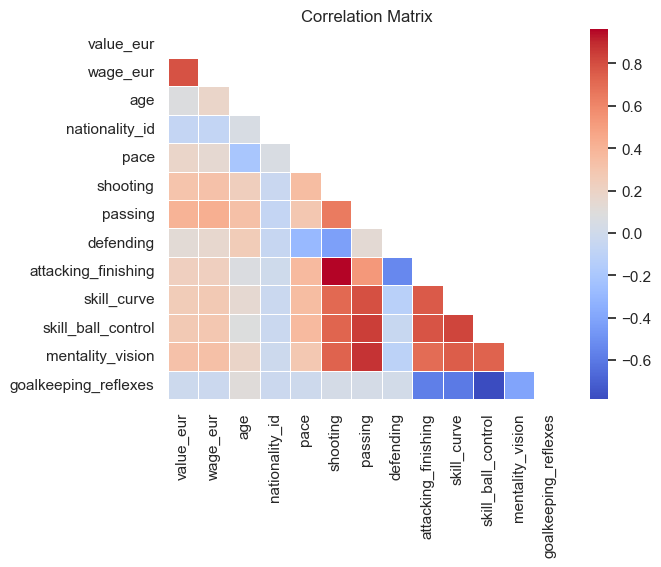

In [27]:
correlation_matrix = dataset_df.corr()

sb.set(style="white")
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sb.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()